In [1]:
#1. Завантажити необхідні дані
import numpy as np
print(np.__version__)
import pandas as pd

data = pd.read_csv("tripadvisor_hotel_reviews.csv")


1.26.4


In [3]:
#2. Підготувати дані на основі підходів з роботи 10

import numpy as np
print(np.__version__)
import nltk
import spacy
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Переведення в нижній регістр
    text = text.lower()

    # Токенізація
    tokens = word_tokenize(text)

    # Видалення пунктуації та стоп-слів
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]

    # Лематизація
    doc = nlp(" ".join(tokens))
    lemmatized = [token.lemma_ for token in doc if token.lemma_ not in stop_words]

    return " ".join(lemmatized)

data['Cleaned'] = data['Review'].apply(preprocess_text)

vectorizer = CountVectorizer(max_df=0.95, min_df=2)  # Мінімальна/максимальна частотність
X = vectorizer.fit_transform(data['Cleaned'])

print(X.shape)

print(data.head())

1.26.4
(9699, 13024)
                                              Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                                             Cleaned  
0  nice hotel expensive parking get good deal sta...  
1  ok nothing special charge diamond member hilto...  
2  nice room experience hotel monaco seattle good...  
3  unique great stay wonderful time hotel monaco ...  
4  great stay great stay go seahawk game awesome ...  


In [5]:
#3. Оцінити тексти за показниками polarity та subjectivity в межах кожної категорії
from textblob import TextBlob

# Функції для обчислення polarity та subjectivity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Додаємо колонки з результатами
data['Polarity'] = data['Cleaned'].apply(get_polarity)
data['Subjectivity'] = data['Cleaned'].apply(get_subjectivity)

grouped = data.groupby('Rating')[['Polarity', 'Subjectivity']].mean()

print(grouped)


        Polarity  Subjectivity
Rating                        
1      -0.019437      0.564315
2       0.119706      0.554100
3       0.208810      0.563076
4       0.295768      0.591189
5       0.354999      0.621679


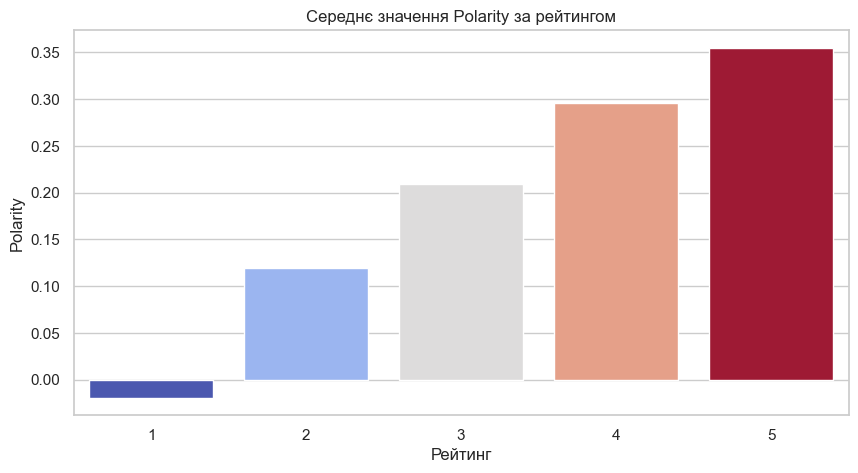

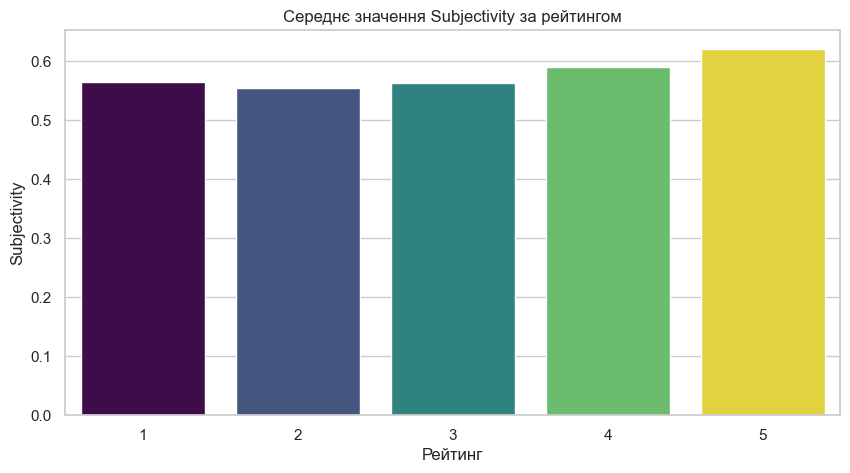

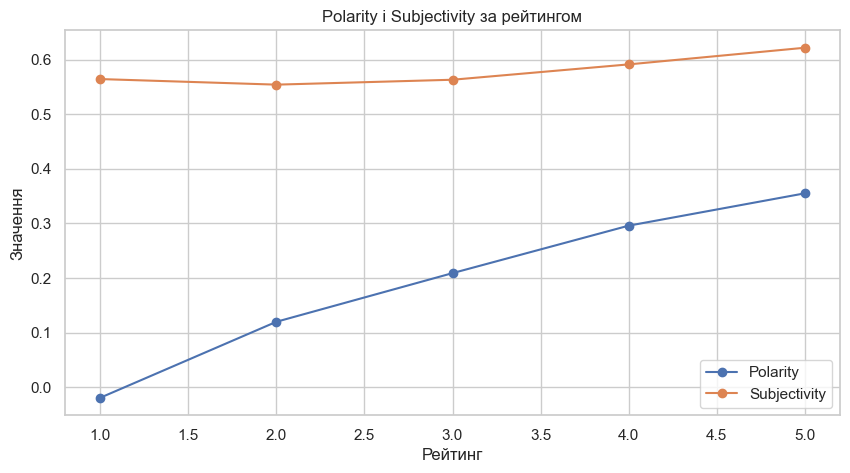

In [7]:
#4. Візуалізувати отримані результати за категоріями (класами) та показниками
import matplotlib.pyplot as plt
import seaborn as sns

# Встановимо стиль для графіків
sns.set(style="whitegrid")

# Побудова графіка для середньої polarity
plt.figure(figsize=(10, 5))
sns.barplot(x=grouped.index, y=grouped['Polarity'], hue=grouped.index, palette="coolwarm", legend=False)
plt.title('Середнє значення Polarity за рейтингом')
plt.xlabel('Рейтинг')
plt.ylabel('Polarity')
plt.show()

# Побудова графіка для середньої subjectivity
plt.figure(figsize=(10, 5))
sns.barplot(x=grouped.index, y=grouped['Subjectivity'], hue=grouped.index, palette="viridis", legend=False)
plt.title('Середнє значення Subjectivity за рейтингом')
plt.xlabel('Рейтинг')
plt.ylabel('Subjectivity')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(grouped.index, grouped['Polarity'], marker='o', label='Polarity')
plt.plot(grouped.index, grouped['Subjectivity'], marker='o', label='Subjectivity')
plt.title('Polarity і Subjectivity за рейтингом')
plt.xlabel('Рейтинг')
plt.ylabel('Значення')
plt.legend()
plt.grid(True)
plt.show()


              precision    recall  f1-score   support

    negative       0.91      0.22      0.35      1640
     neutral       0.15      0.07      0.10      1072
    positive       0.79      0.99      0.88      6987

    accuracy                           0.76      9699
   macro avg       0.61      0.43      0.44      9699
weighted avg       0.74      0.76      0.70      9699



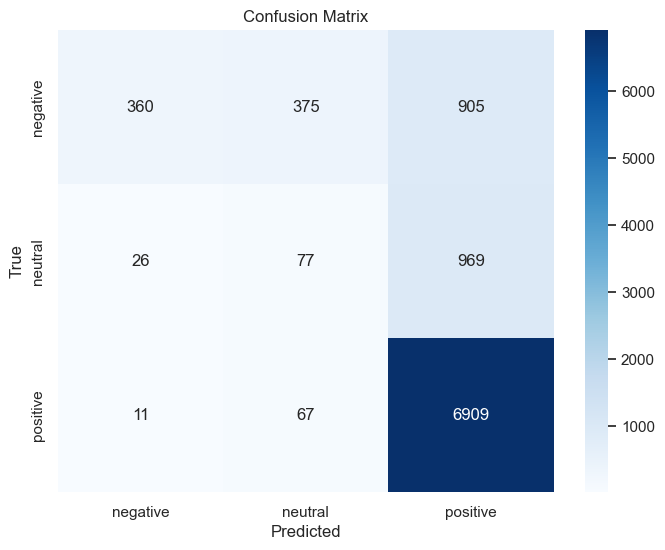

In [9]:
#5. Якщо дані дають таку можливість - провести оцінку якості роботи алгоритму
def label_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

data['TrueSentiment'] = data['Rating'].apply(label_sentiment)

def predict_sentiment(polarity):
    if polarity < -0.05:
        return 'negative'
    elif polarity > 0.05:
        return 'positive'
    else:
        return 'neutral'

data['PredictedSentiment'] = data['Polarity'].apply(predict_sentiment)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(data['TrueSentiment'], data['PredictedSentiment']))

# Матриця неточностей
conf_mat = confusion_matrix(data['TrueSentiment'], data['PredictedSentiment'], labels=['negative', 'neutral', 'positive'])

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [11]:
#6. Визначити іменники в досліджуваному тексті для конкретизації його тематики
from textblob import TextBlob
from textblob import Word
import random
import nltk
nltk.download('averaged_perceptron_tagger_eng')

def extract_nouns_textblob(text):
    blob = TextBlob(text)
    nouns = list()
    # Проходимо по тегах і додаємо тільки іменники (NN)
    for word, tag in blob.tags:
        if tag == "NN":
            nouns.append(word.lemmatize())  # Лематизація іменників
    return nouns

# Застосовуємо до очищеного тексту
data['Nouns'] = data['Cleaned'].apply(extract_nouns_textblob)

print("This text is about...")
for item in random.sample(data['Nouns'].iloc[0], 5):
    word = Word(item)
    print(word.pluralize())  

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


This text is about...
stays
sizes
parkings
shops
soundproofs


In [15]:
#7. Провести моделювання тематики тексту та підібрати оптимальні параметри (за характеристиками тексту та параметрами алгоритму), 
#зокрема, підібрати оптимальну кількість тем.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV


vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(data['Cleaned'])

lda = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online', random_state=0)
lda.fit(X)

search_params = {'n_components': [3, 5, 7, 10], 'learning_decay': [0.5, 0.7, 0.9]}
lda_model = LatentDirichletAllocation(max_iter=10, learning_method='online', random_state=42)
model = GridSearchCV(lda_model, param_grid=search_params)
model.fit(X)

best_lda_model = model.best_estimator_
print("Найкраща кількість тем:", best_lda_model.n_components)



Найкраща кількість тем: 3


In [47]:
#8. Візуалізувати отримані результати щодо тематики тексту 
def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Тема {idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

feature_names = vectorizer.get_feature_names_out()
display_topics(best_lda_model, feature_names, 10)

Тема 1:
room hotel stay tell day say night service desk check

Тема 2:
beach resort good food pool great day time restaurant room

Тема 3:
hotel room stay great good location staff nice breakfast clean

